
# <u>Cardiovascular Death Rate Capstone: Random Forest</u>
*An example in the importance of a good feature set...*

In [1]:
# Importing Modules
#------------------------#
# Importing modules for DataFrames, plots, and statistical analysis
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.legend_handler import HandlerLine2D
sns.set();
#------------------------#
# Importing classification algorithms
from sklearn.ensemble import RandomForestClassifier
#------------------------#
# Importing modules to measure model performance
import time 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

**Column selection**

In [2]:
# load data set into DataFrame.
cdr = pd.read_csv('data/cdr_data.csv',index_col=0)

# Drop columns for significance of difference.
ss = [col for col in cdr.columns if 'SS' in col]
cdr = cdr.drop(columns=ss)

# Cast 'rate_change' as an int
cdr['rate_change'] = cdr['rate_change'].astype(int)

# Select only these columns from the DataFrame.
col_list = cdr.columns[7:].to_list()
cdr = cdr[col_list]

# Print first few rows.
cdr.head()

,rate_change,CP02_current_058E,CP02_previous_058E,CP02_diff_058E,CP02_current_059E,CP02_previous_059E,CP02_diff_059E,CP02_current_060E,CP02_previous_060E,CP02_diff_060E,...,CP04_diff_138E,CP04_current_139E,CP04_previous_139E,CP04_diff_139E,CP04_current_140E,CP04_previous_140E,CP04_diff_140E,CP04_current_141E,CP04_previous_141E,CP04_diff_141E
0,0,90930.0,90844.0,86.0,3.0,4.6,-1.6,7.9,8.0,-0.1,...,3.5,10.4,10.5,-0.1,47.4,38.2,9.2,1126.0,819.0,307.0
1,0,49654.0,48361.0,1293.0,2.5,2.0,0.5,4.0,4.2,-0.2,...,11.9,13.4,12.7,0.7,32.8,45.7,-12.9,855.0,668.0,187.0
2,1,74278.0,73273.0,1005.0,1.2,2.6,-1.4,5.7,5.2,0.5,...,11.1,9.6,11.9,-2.3,39.2,40.9,-1.7,790.0,417.0,373.0
3,1,280301.0,280659.0,-358.0,2.7,2.7,0.0,8.1,8.8,-0.7,...,-1.7,9.4,8.3,1.1,52.7,55.0,-2.3,4706.0,4204.0,502.0
4,1,62370.0,61645.0,725.0,1.9,1.3,0.6,6.0,6.9,-0.9,...,-1.7,10.0,6.0,4.0,47.7,50.4,-2.7,151.0,706.0,-555.0


**<u>Dealing with missing values:</u>**

**As was done for attempting a decision tree model, the missing data will be handled using listwise, or complete, deletion.**

In [3]:
# Get 'DataFrame to create feature and target arrays.
df = cdr.copy()

# Drop all entries with missing values.
df = df.dropna().reset_index(drop=True)

## <u>Step 1: Build a default random forest</u>
****

*A random forest will be fit to the data, using the entire feature space and default parameter values.*

In [4]:
# Create feature and target arrays.
X = df.drop('rate_change',axis=1).values
y = df['rate_change'].values

# Examine shape of feature and target arrays.
print('Shape of feature array: ',X.shape)
print('Shape of target array: ',y.shape)

Shape of feature array:  (4232, 252)
Shape of target array:  (4232,)


In [5]:
# Set random_state variable.
SEED = 42

# create train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=SEED)

# print shapes of train and test sets.
print('Shape of train features: ',X_train.shape)
print('Shape of train targets: ',y_train.shape)
print('Shape of test features: ',X_test.shape)
print('Shape of test targets: ',y_test.shape)

Shape of train features:  (2962, 252)
Shape of train targets:  (2962,)
Shape of test features:  (1270, 252)
Shape of test targets:  (1270,)


In [6]:
# Instantiate a RandomForestClassifier 'rf' with default parameters.
rf = RandomForestClassifier(random_state=SEED)

# Fit rf to the training set.
rf.fit(X_train,y_train)

# Predict test set labels and probabilities.
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:,1]

# Compute test set performance metrics.  
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print performance metric scores.
print("Test set accuracy: {:.2f}".format(acc))
print('ROC AUC score: {:.2f}'.format(roc_auc))

Test set accuracy: 0.54
ROC AUC score: 0.53


## <u>Step 2: Parameter Tuning</u>
****

### <u>Number of Estimators</u>

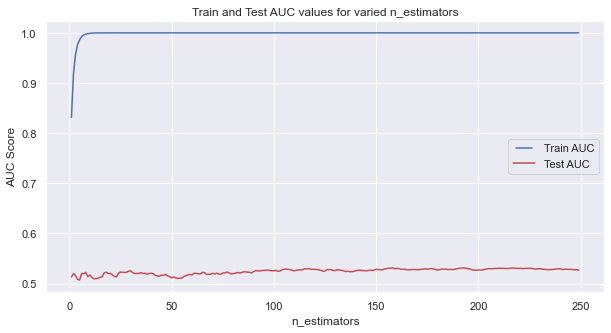

In [8]:
# define range of depths to check: depth_vals
est_vals = np.arange(1,250)

# initialize empty lists to store scores: train_scores, test_scores
train_scores = []
test_scores = []

# iterate over est_vals, and record the training and test scores
for est in est_vals:
    
    # instantiate a classifier with max_depth value
    rf = RandomForestClassifier(n_estimators=est,random_state=SEED)
    
    # fit the tree to the training set
    rf.fit(X_train,y_train)
    
    # predict on the train and test sets: pred_train,pred_test
    prob_train = rf.predict_proba(X_train)[:,1]
    prob_test = rf.predict_proba(X_test)[:,1]
    
    # store the AUC scores in corresponding lists
    train_scores.append(roc_auc_score(y_train,prob_train))
    test_scores.append(roc_auc_score(y_test,prob_test))
    
# plot the train and test scores on the same figure
plt.figure(figsize=(10,5))
line1, = plt.plot(est_vals, train_scores, 'b', label="Train AUC")
line2, = plt.plot(est_vals, test_scores, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC Score")
plt.xlabel("n_estimators")
plt.title("Train and Test AUC values for varied n_estimators")
plt.show()

### <u>Max Depth</u>

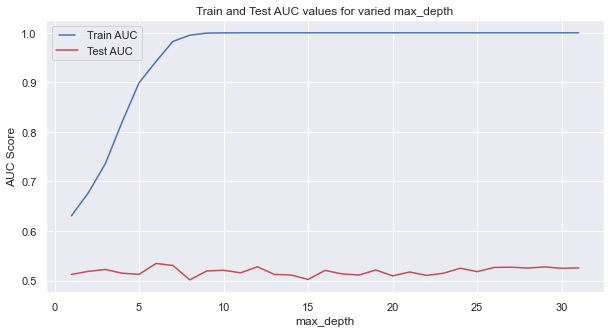

In [9]:
# define range of depths to check: depth_vals
depth_vals = np.arange(1,32)

# initialize empty lists to store scores: train_scores, test_scores
train_scores = []
test_scores = []

# iterate over depth_vals, and record the training and test scores
for depth in depth_vals:
    
    # instantiate a classifier with max_depth value
    rf = RandomForestClassifier(max_depth=depth,random_state=SEED)
    
    # fit the tree to the training set
    rf.fit(X_train,y_train)
    
    # predict on the train and test sets: pred_train,pred_test
    prob_train = rf.predict_proba(X_train)[:,1]
    prob_test = rf.predict_proba(X_test)[:,1]
    
    # store the AUC scores in corresponding lists
    train_scores.append(roc_auc_score(y_train,prob_train))
    test_scores.append(roc_auc_score(y_test,prob_test))
    
# plot the train and test scores on the same figure
plt.figure(figsize=(10,5))
line1, = plt.plot(depth_vals, train_scores, 'b', label="Train AUC")
line2, = plt.plot(depth_vals, test_scores, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC Score")
plt.xlabel("max_depth")
plt.title("Train and Test AUC values for varied max_depth")
plt.show()

Now we repeat this process for the next parameters, min_samples_split and min_samples_leaf.

### <u>Min Samples Split / Min Samples Leaf</u>

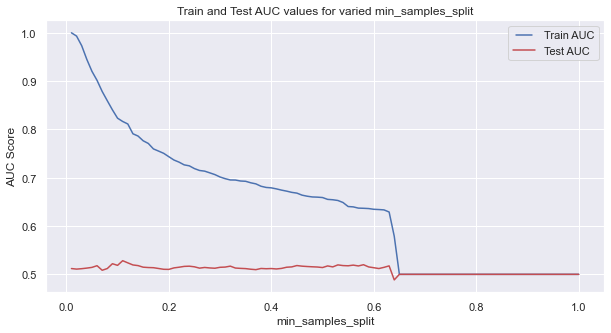

In [11]:
# define range of minimum split samples to check: split_vals
split_vals = np.linspace(.01, 1.0, 100, endpoint=True)

# initialize empty lists to store scores: train_scores, test_scores
train_scores = []
test_scores = []

# iterate over split_vals, and record the training and test scores
for split in split_vals:
    
    # instantiate a classifier with min_samples_split value
    rf = RandomForestClassifier(min_samples_split=split,random_state=SEED)
    
    # fit the tree to the training set
    rf.fit(X_train,y_train)
    
    # predict on the train and test sets: pred_train,pred_test
    prob_train = rf.predict_proba(X_train)[:,1]
    prob_test = rf.predict_proba(X_test)[:,1]
    
    # store the AUC scores in corresponding lists
    train_scores.append(roc_auc_score(y_train,prob_train))
    test_scores.append(roc_auc_score(y_test,prob_test))
    
# plot the train and test scores on the same figure
plt.figure(figsize=(10,5))
line1, = plt.plot(split_vals, train_scores, 'b', label="Train AUC")
line2, = plt.plot(split_vals, test_scores, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC Score")
plt.xlabel("min_samples_split")
plt.title("Train and Test AUC values for varied min_samples_split")
plt.show()

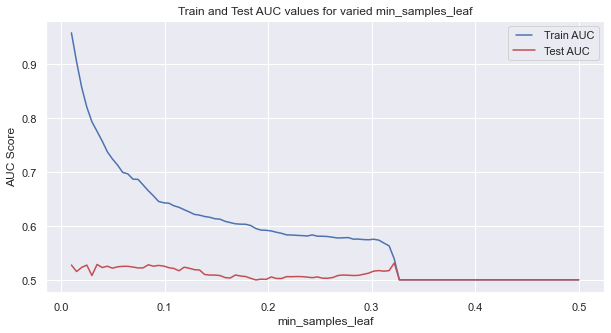

In [12]:
# define range of minimum leaf samples to check: leaf_vals
leaf_vals = np.linspace(.01, 0.5, 100, endpoint=True)

# initialize empty lists to store scores: train_scores, test_scores
train_scores = []
test_scores = []

# iterate over leaf_vals, and record the training and test scores
for leaf in leaf_vals:
    
    # instantiate a classifier with min_samples_leaf value
    rf = RandomForestClassifier(min_samples_leaf=leaf,random_state=SEED)
    
    # fit the tree to the training set
    rf.fit(X_train,y_train)
    
    # predict on the train and test sets: pred_train,pred_test
    prob_train = rf.predict_proba(X_train)[:,1]
    prob_test = rf.predict_proba(X_test)[:,1]
    
    # store the AUC scores in corresponding lists
    train_scores.append(roc_auc_score(y_train,prob_train))
    test_scores.append(roc_auc_score(y_test,prob_test))
    
# plot the train and test scores on the same figure
plt.figure(figsize=(10,5))
line1, = plt.plot(leaf_vals, train_scores, 'b', label="Train AUC")
line2, = plt.plot(leaf_vals, test_scores, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC Score")
plt.xlabel("min_samples_leaf")
plt.title("Train and Test AUC values for varied min_samples_leaf")
plt.show()

The next parameter to check will be the maximum number of features to consider for each split, max_features.

### <u>Max Features</u>

In [16]:
list(np.arange(1,X.shape[1],20))

[1, 21, 41, 61, 81, 101, 121, 141, 161, 181, 201, 221, 241]

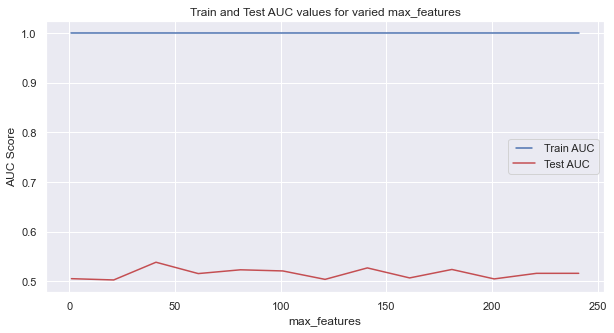

In [17]:
# define range of max features to check: feat_vals
feat_vals = list(np.arange(1,X.shape[1],20))

# initialize empty lists to store scores: train_scores, test_scores
train_scores = []
test_scores = []

# iterate over feat_vals, and record the training and test scores
for feat in feat_vals:
    
    # instantiate a classifier with max_features value
    rf = RandomForestClassifier(max_features=feat,random_state=SEED)
    
    # fit the tree to the training set
    rf.fit(X_train,y_train)
    
    # predict on the train and test sets: pred_train,pred_test
    prob_train = rf.predict_proba(X_train)[:,1]
    prob_test = rf.predict_proba(X_test)[:,1]
    
    # store the AUC scores in corresponding lists
    train_scores.append(roc_auc_score(y_train,prob_train))
    test_scores.append(roc_auc_score(y_test,prob_test))
    
# plot the train and test scores on the same figure
plt.figure(figsize=(10,5))
line1, = plt.plot(feat_vals, train_scores, 'b', label="Train AUC")
line2, = plt.plot(feat_vals, test_scores, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC Score")
plt.xlabel("max_features")
plt.title("Train and Test AUC values for varied max_features")
plt.show()

**Grid search hyperparameter tuning**

In [19]:
# Instantiate a RandomForestClassifier 'rf' with default parameters.
rf = RandomForestClassifier(random_state=SEED)

# Define params_rf.
params_rf = {
    'max_depth':[6,7,12],
    'min_samples_split':list(np.linspace(0.1,0.15,10)),
    'min_samples_leaf':list(np.linspace(0.05,0.1,10)),
    'max_features':[41,141,181]
}



# Instantiate grid_rf.
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='roc_auc',
                       cv=10,
                       n_jobs=-1)

# Train grid_rf.
grid_rf.fit(X_train, y_train)

# Extract the best estimator.
best_model = grid_rf.best_estimator_

# Extract parameters of best estimator.
best_params = best_model.get_params()

# Predict the test set probabilities of the positive class.
y_pred_proba = best_model.predict_proba(X_test)[:,1]

# Compute test_roc_auc.
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print test_roc_auc.
print('Test set ROC AUC score: {:.3f}'.format(test_roc_auc))

Test set ROC AUC score: 0.527


**Feature Selection**

We check to see if performance improved if the feature set is reduced to only include features with non-zero feature importance values.

In [20]:
feat_imps = best_model.feature_importances_
feat_cols = df.drop('rate_change',axis=1).columns

In [21]:
df_imps = pd.DataFrame(feat_imps,index=feat_cols,columns=['imp'])
df_imps = df_imps[df_imps.imp>0]
df_imps = df_imps.sort_values(by='imp',ascending=False)
new_cols = ['rate_change']+df_imps.index.to_list()
df = cdr[new_cols].copy()

# Drop all entries with missing values.
df = df.dropna().reset_index(drop=True)

In [22]:
# Create feature and target arrays.
X = df.drop('rate_change',axis=1).values
y = df['rate_change'].values

# Examine shape of feature and target arrays.
print('Shape of feature array: ',X.shape)
print('Shape of target array: ',y.shape)

Shape of feature array:  (4232, 211)
Shape of target array:  (4232,)


In [23]:
# Set random_state variable.
SEED = 42

# create train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=SEED)

# print shapes of train and test sets.
print('Shape of train features: ',X_train.shape)
print('Shape of train targets: ',y_train.shape)
print('Shape of test features: ',X_test.shape)
print('Shape of test targets: ',y_test.shape)

Shape of train features:  (2962, 211)
Shape of train targets:  (2962,)
Shape of test features:  (1270, 211)
Shape of test targets:  (1270,)


In [25]:
# Instantiate new classifier and set parameters.
rf = RandomForestClassifier().set_params(**best_params)

# Fit the model.
rf.fit(X_train, y_train)

# Predict the test set probabilities of the positive class
y_pred_proba = rf.predict_proba(X_test)[:,1]

# Compute test_roc_auc
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print test_roc_auc
print('Test set ROC AUC score: {:.3f}'.format(test_roc_auc))

Test set ROC AUC score: 0.523


The attempt at creating a model using a random forest has also failed in the same way as a decision tree. The conclusion can be made that there is an underlying issue with the data set itself. In particular, it would appear that the feature set lacks the predictive power needed to accomplish the goal of the project. 